# Homework 1

## Check installazione spark

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkConf
from pyspark.context import SparkContext

conf = (
    SparkConf()
      # Configurazione per abilitare il Security Manager e risolvere i problemi legati a Java
      .set("spark.driver.extraJavaOptions",   "-Djava.security.manager=allow")
)

sc = SparkContext.getOrCreate(conf=conf)

print("Java:", sc._jvm.System.getProperty("java.version"))
print("Spark:", sc.version)

assert  "3." in sc.version, "Verify that the cluster Spark's version is 3.x"


25/05/11 20:19:25 WARN Utils: Your hostname, MacBook-Pro-di-Leonardo.local resolves to a loopback address: 127.0.0.1; using 192.168.7.220 instead (on interface en0)
25/05/11 20:19:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/11 20:19:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Java: 23.0.2
Spark: 3.5.5


In [3]:
print("Spark version:", sc.version)

Spark version: 3.5.5


In [4]:
from pyspark.sql import SparkSession
spark_session = SparkSession(sc)

## Lettura Dataset

Il blocco di codice successivo serve a:
1. Usare la prima riga automaticamente come header  
2. Fare inferenza automatica sul tipo di dato di ogni colonna  
3. Gestire records multi-linea  
4. Specificare che sono usate le doppie virgolette per racchiudere i campi  
5. Gestire le virgolette all'interno dei campi racchiusi dalle stesse  
6. Permettere il parsing di record non formattati perfettamente senza fallire  
7. Specificare il path del file `.csv` da cui leggere  

In [5]:
# Load the CSV file into a DataFrame
df_clinical = spark_session.read \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .option("multiLine", "true") \
  .option("quote", '"') \
  .option("escape", '"') \
  .option("mode", "PERMISSIVE") \
  .csv('dimensions_clinicalTrials.csv') 

In [6]:
df_clinical.printSchema()  # Prints the schema of the DataFrame

root
 |-- Rank: integer (nullable = true)
 |-- Trial ID: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Brief title: string (nullable = true)
 |-- Acronym: string (nullable = true)
 |-- Abstract: string (nullable = true)
 |-- Start date: date (nullable = true)
 |-- Start Year: double (nullable = true)
 |-- End Date: date (nullable = true)
 |-- Completion Year: double (nullable = true)
 |-- Phase: string (nullable = true)
 |-- Study Type: string (nullable = true)
 |-- Study Design: string (nullable = true)
 |-- Conditions: string (nullable = true)
 |-- Recruitment Status: string (nullable = true)
 |-- Number of Participants: double (nullable = true)
 |-- Intervention: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Registry: string (nullable = true)
 |-- Investigators/Contacts: string (nullable = true)
 |-- Sponsors/Collaborators: string (nullable = true)
 |-- City of Sponsor/Collaborator: string (nullable = true

In [7]:
df_clinical.show(5)  # Displays the first 5 rows of the DataFrame

25/05/11 20:19:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+--------------+--------------------+--------------------+-----------------+--------------------+----------+----------+----------+---------------+-------+--------------+--------------------+--------------------+------------------+----------------------+--------------------+------+-------------------+------------------+----------------------+----------------------+----------------------------+-----------------------------+-------------------------------+---------------------+------------+--------------+--------------------+-------------------------+--------------------+--------------------------------+--------------------+--------------------+-------------------+------------+--------------+---------------+
|Rank|      Trial ID|               Title|         Brief title|          Acronym|            Abstract|Start date|Start Year|  End Date|Completion Year|  Phase|    Study Type|        Study Design|          Conditions|Recruitment Status|Number of Participants|        Intervention|G

## Analytics di esempio

Numero di studi cominciati per anno

In [8]:
df_clinical.filter(df_clinical["Start Year"].isNotNull()) \
    .groupBy("Start Year") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(10)  # Displays the count of clinical trials by start year

+----------+-----+
|Start Year|count|
+----------+-----+
|    2021.0| 1460|
|    2020.0| 1438|
|    2019.0| 1321|
|    2018.0| 1207|
|    2022.0| 1151|
|    2017.0| 1146|
|    2016.0|  850|
|    2015.0|  841|
|    2013.0|  784|
|    2014.0|  767|
+----------+-----+
only showing top 10 rows



Numero medio di partecipanti per tipo di studio

In [9]:
from pyspark.sql.functions import avg, round

df_clinical.filter(df_clinical["Number of Participants"].isNotNull()) \
    .groupBy("Study Type") \
    .agg(round(avg("Number of Participants"), 2).alias("avg_participants")) \
    .orderBy("avg_participants", ascending = False) \
    .show(10)  # Displays the average number (roundend to the .2 decimal) of participants by study type

+-------------------+----------------+
|         Study Type|avg_participants|
+-------------------+----------------+
|Active surveillance|        115000.0|
| Non-interventional|          3260.8|
|      Observational|         2632.76|
|     Interventional|          660.18|
|                CCT|           520.0|
|              Other|           202.0|
+-------------------+----------------+



Top 10 medical conditions più presenti

In [10]:
df_clinical.filter(df_clinical["Conditions"].isNotNull()) \
    .groupBy("Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(10)  # Displays the top 10 count of clinical trials by condition

+--------------------+-----+
|          Conditions|count|
+--------------------+-----+
|       Breast Cancer|  281|
|    Multiple Myeloma|  179|
|      Ovarian Cancer|  126|
|            Melanoma|  118|
|  Ulcerative Colitis|  112|
|Acute Myeloid Leu...|  106|
|            Leukemia|  102|
|Carcinoma, Non-Sm...|  101|
| Follicular Lymphoma|   92|
|Metastatic Colore...|   90|
+--------------------+-----+
only showing top 10 rows



Paesi con il numero più alto di partecipanti

In [11]:
df_clinical.filter(df_clinical["Number of Participants"].isNotNull() & df_clinical["Funder Country"].isNotNull()) \
    .groupBy("Funder Country") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(10)  # Displays the top 10 count of clinical trials by funder country

+--------------------+-----+
|      Funder Country|count|
+--------------------+-----+
|       United States| 2785|
|               Italy| 1797|
|             Germany|  391|
|               Japan|  325|
|             Belgium|  240|
|        Italy; Italy|  182|
|         Switzerland|  165|
|United States; Un...|  107|
|      United Kingdom|   91|
|United States; Japan|   68|
+--------------------+-----+
only showing top 10 rows



Si può notare che esistono anche duplicati o paesi che hanno probabilmente una collaborazione (separati da ;) che sono presenti in conteggi separati. Pertanto è utile provare a separarli.

In [12]:
from pyspark.sql.functions import split, explode, trim

# Split the 'Funder Country' column by ';' and explode it into separate rows
df_cleaned = df_clinical.withColumn("Funder Country", explode(split(df_clinical["Funder Country"], ";")))

# Remove leading/trailing whitespace from country names
df_cleaned = df_cleaned.withColumn("Funder Country", trim(df_cleaned["Funder Country"]))

# Filter out null values and group by 'Funder Country'
df_cleaned.filter(df_cleaned["Number of Participants"].isNotNull() & df_cleaned["Funder Country"].isNotNull()) \
    .groupBy("Funder Country") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(10)  # Displays the top 10 count of clinical trials by funder country

+--------------+-----+
|Funder Country|count|
+--------------+-----+
| United States| 3662|
|         Italy| 2939|
|       Germany|  602|
|         Japan|  547|
|United Kingdom|  408|
|       Belgium|  347|
|   Switzerland|  278|
|   Netherlands|  197|
|        France|  150|
|       Denmark|   82|
+--------------+-----+
only showing top 10 rows



## Analytics proposte

### Distribuzione delle Age Groups in base alle condizioni

In [13]:
#Si sono filtrati i dati per età e condizioni, e sono stati esclusi i valori nulli e le righe con "None - None" o "N/A - N/A"
df_clinical.filter(df_clinical["Age"].isNotNull() & df_clinical["Conditions"].isNotNull() & (df_clinical["Age"] != "None - None") & (df_clinical["Age"] != "N/A - N/A")) \
    .groupBy("Age", "Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(10) 

+--------------+--------------------+-----+
|           Age|          Conditions|count|
+--------------+--------------------+-----+
|18 Years - N/A|       Breast Cancer|  212|
|18 Years - N/A|    Multiple Myeloma|  159|
|18 Years - N/A|      Ovarian Cancer|   99|
|18 Years - N/A|Carcinoma, Non-Sm...|   97|
|18 Years - N/A|Non-Small Cell Lu...|   78|
|18 Years - N/A|Metastatic Breast...|   77|
|18 Years - N/A| Follicular Lymphoma|   69|
|18 Years - N/A|       Heart Failure|   66|
|18 Years - N/A|            Melanoma|   66|
|18 Years - N/A|Chronic Myeloid L...|   64|
+--------------+--------------------+-----+
only showing top 10 rows



In [14]:
#Qui si è sceso nel particolare delle top 3 Condizioni, per vedere le età più comuni per ciascuna di esse
df_clinical.filter(df_clinical["Age"].isNotNull() & (df_clinical["Conditions"] == "Breast Cancer") & (df_clinical["Age"] != "None - None") & (df_clinical["Age"] != "N/A - N/A") ) \
    .groupBy("Age", "Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(5) 

df_clinical.filter(df_clinical["Age"].isNotNull() & (df_clinical["Conditions"] == "Multiple Myeloma") & (df_clinical["Age"] != "None - None") & (df_clinical["Age"] != "N/A - N/A") ) \
    .groupBy("Age", "Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(5) 

df_clinical.filter(df_clinical["Age"].isNotNull() & (df_clinical["Conditions"] == "Ovarian Cancer") & (df_clinical["Age"] != "None - None") & (df_clinical["Age"] != "N/A - N/A") ) \
    .groupBy("Age", "Conditions") \
    .count() \
    .orderBy("count", ascending = False) \
    .show(5) 

+-------------------+-------------+-----+
|                Age|   Conditions|count|
+-------------------+-------------+-----+
|     18 Years - N/A|Breast Cancer|  212|
|18 Years - 70 Years|Breast Cancer|    8|
|18 Years - 75 Years|Breast Cancer|    7|
|     N/A - 70 Years|Breast Cancer|    4|
|18 Years - 45 Years|Breast Cancer|    4|
+-------------------+-------------+-----+
only showing top 5 rows



25/05/11 20:19:39 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------------------+----------------+-----+
|                Age|      Conditions|count|
+-------------------+----------------+-----+
|     18 Years - N/A|Multiple Myeloma|  159|
|18 Years - 65 Years|Multiple Myeloma|    8|
|18 Years - 70 Years|Multiple Myeloma|    5|
|     65 Years - N/A|Multiple Myeloma|    2|
|18 Years - 80 Years|Multiple Myeloma|    1|
+-------------------+----------------+-----+

+-------------------+--------------+-----+
|                Age|    Conditions|count|
+-------------------+--------------+-----+
|     18 Years - N/A|Ovarian Cancer|   99|
|18 Years - 75 Years|Ovarian Cancer|    9|
|     N/A - 75 Years|Ovarian Cancer|    7|
|     70 Years - N/A|Ovarian Cancer|    2|
|18 Years - 65 Years|Ovarian Cancer|    2|
+-------------------+--------------+-----+
only showing top 5 rows



Partendo dai risultati precedenti, si è proceduto ad estrarre la Start Age dell'Age Group per raggruppare il campione su tale base.

In [15]:
from pyspark.sql.functions import split

df_clinical_with_start_age = df_clinical.withColumn("Start Age", split(df_clinical["Age"], " ")[0])

df_clinical_with_start_age.filter(
    df_clinical_with_start_age["Age"].isNotNull() & 
    (df_clinical_with_start_age["Conditions"] == "Breast Cancer") & 
    (df_clinical_with_start_age["Age"] != "None - None") & 
    (df_clinical_with_start_age["Age"] != "N/A - N/A")
) \
    .groupBy("Start Age", "Conditions") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(5)

df_clinical_with_start_age.filter(
    df_clinical_with_start_age["Age"].isNotNull()& 
    (df_clinical_with_start_age["Conditions"] == "Multiple Myeloma") & 
    (df_clinical_with_start_age["Age"] != "None - None") & 
    (df_clinical_with_start_age["Age"] != "N/A - N/A")
) \
    .groupBy("Start Age", "Conditions") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(5)

df_clinical_with_start_age.filter(
    df_clinical_with_start_age["Age"].isNotNull() & 
    (df_clinical_with_start_age["Conditions"] == "Ovarian Cancer") & 
    (df_clinical_with_start_age["Age"] != "None - None") & 
    (df_clinical_with_start_age["Age"] != "N/A - N/A")
) \
    .groupBy("Start Age", "Conditions") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(5)

+---------+-------------+-----+
|Start Age|   Conditions|count|
+---------+-------------+-----+
|       18|Breast Cancer|  246|
|       65|Breast Cancer|    6|
|       45|Breast Cancer|    6|
|      N/A|Breast Cancer|    5|
|       40|Breast Cancer|    4|
+---------+-------------+-----+
only showing top 5 rows



+---------+----------------+-----+
|Start Age|      Conditions|count|
+---------+----------------+-----+
|       18|Multiple Myeloma|  173|
|       65|Multiple Myeloma|    2|
+---------+----------------+-----+

+---------+--------------+-----+
|Start Age|    Conditions|count|
+---------+--------------+-----+
|       18|Ovarian Cancer|  111|
|      N/A|Ovarian Cancer|    7|
|       70|Ovarian Cancer|    2|
+---------+--------------+-----+



### Anomaly Detection Analysis

In questo caso si è cercato di fare una anomaly detection basandosi sul numero di partecipanti ad ogni trial. Usando il metodo IQR (Inter-Quartile Range) si identificano i Trial che hanno un alto o un basso numero di partecipanti con la stessa condizione.

In [16]:
from pyspark.sql.functions import col, expr, percentile_approx, first

# Calculate Q1, Q3, and IQR for each condition
iqr_stats = df_clinical.filter(df_clinical["Number of Participants"].isNotNull()) \
    .groupBy("Conditions") \
    .agg(
        percentile_approx("Number of Participants", 0.25).alias("Q1"),
        percentile_approx("Number of Participants", 0.75).alias("Q3")
    ) \
    .withColumn("IQR", col("Q3") - col("Q1")) \
    .withColumn("Lower_Bound", col("Q1") - 1.5 * col("IQR")) \
    .withColumn("Upper_Bound", col("Q3") + 1.5 * col("IQR"))

# Join the IQR stats back to the original DataFrame
df_with_iqr = df_clinical.filter(df_clinical["Number of Participants"].isNotNull()) \
    .join(iqr_stats, on="Conditions", how="inner")

# Flag anomalies based on IQR
anomalies = df_with_iqr.filter(
    (col("Number of Participants") < col("Lower_Bound")) |
    (col("Number of Participants") > col("Upper_Bound"))
)

# Select records within the bounds
valid_records = df_with_iqr.filter(
    (col("Number of Participants") >= col("Lower_Bound")) &
    (col("Number of Participants") <= col("Upper_Bound"))
)

# Group by Conditions and select the first anomaly for each condition
unique_anomalies = anomalies.groupBy("Conditions").agg(
    first("Number of Participants").alias("Number of Participants"),
    first("Lower_Bound").alias("Lower_Bound"),
    first("Upper_Bound").alias("Upper_Bound"),
    first("Trial ID").alias("Trial ID")
)

# Show unique anomalies with full-length Conditions column
print("Anomalies:")
unique_anomalies.show(10,truncate=False)

# Show valid records with study information
print("Valid Records:")
valid_records.select("Conditions", "Number of Participants", "Lower_Bound", "Upper_Bound", "Trial ID").show(10,truncate=False)

Anomalies:


+----------------------------------+----------------------+-----------+-----------+-----------+
|Conditions                        |Number of Participants|Lower_Bound|Upper_Bound|Trial ID   |
+----------------------------------+----------------------+-----------+-----------+-----------+
|AL Amyloidosis                    |5000.0                |-20.0      |140.0      |NCT04839003|
|AML                               |246.0                 |367.0      |367.0      |NCT02152956|
|ARDS                              |740.0                 |-110.0     |226.0      |NCT03963622|
|Acute Coronary Syndromes          |10000.0               |2597.0     |2597.0     |NCT02438085|
|Acute Leukemia                    |40.0                  |101.0      |101.0      |NCT01385891|
|Acute Lymphoblastic Leukemia      |280.0                 |-70.0      |210.0      |NCT00358072|
|Acute Myelogenous Leukemia        |326.0                 |561.0      |593.0      |NCT00317642|
|Acute Promyelocytic Leukemia      |600.

+--------------------------------------------------------------------+----------------------+-----------+-----------+--------------+
|Conditions                                                          |Number of Participants|Lower_Bound|Upper_Bound|Trial ID      |
+--------------------------------------------------------------------+----------------------+-----------+-----------+--------------+
|Metastatic Renal Cell Carcinoma                                     |118.0                 |48.0       |160.0      |NCT05817903   |
|Implant Infection                                                   |130.0                 |130.0      |130.0      |NCT05482490   |
|Rheumatoid arthritis                                                |240.0                 |-3950.0    |7170.0     |ISRCTN44988547|
|Colitis, Ulcerative                                                 |550.0                 |-911.5     |1780.5     |NCT05242484   |
|Furcation Defects                                                   

### Correlation Analysis tra Visibilità Mediatica e Durata/Partecipanti

In [ ]:
from pyspark.sql.functions import col, to_date, datediff
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

df_corr = df_clinical \
    .filter(
        col("Altmetric Attention Score").isNotNull() &
        col("Number of Participants").isNotNull() &
        col("Start date").isNotNull() &
        col("End Date").isNotNull()
    ) \
    .withColumn("StartDate", to_date(col("Start date"), "yyyy-MM-dd")) \
    .withColumn("EndDate",   to_date(col("End Date"),   "yyyy-MM-dd")) \
    .withColumn("DurationDays", datediff(col("EndDate"), col("StartDate")))

# Correlazione attraverso Pearson e Spearman
pdf = df_corr.select(
    "Altmetric Attention Score",
    "Number of Participants",
    "DurationDays"
).toPandas()

from scipy.stats import pearsonr, spearmanr

pearson_np, p_np = pearsonr(pdf["Altmetric Attention Score"], pdf["Number of Participants"])
spearman_np, sp_p_np = spearmanr(pdf["Altmetric Attention Score"], pdf["Number of Participants"])

pearson_dur, p_dur = pearsonr(pdf["Altmetric Attention Score"], pdf["DurationDays"])
spearman_dur, sp_p_dur = spearmanr(pdf["Altmetric Attention Score"], pdf["DurationDays"])

print(f"Pearson Altmetric vs #Participants: r={pearson_np:.3f}, p={p_np:.3e}")
print(f"Spearman Altmetric vs #Participants: ρ={spearman_np:.3f}, p={sp_p_np:.3e}")
print(f"Pearson Altmetric vs Duration:        r={pearson_dur:.3f}, p={p_dur:.3e}")
print(f"Spearman Altmetric vs Duration:       ρ={spearman_dur:.3f}, p={sp_p_dur:.3e}")

Pearson Altmetric vs #Participants: r=0.005, p=6.786e-01
Spearman Altmetric vs #Participants: ρ=0.274, p=8.738e-112
Pearson Altmetric vs Duration:        r=0.004, p=7.711e-01
Spearman Altmetric vs Duration:       ρ=0.125, p=9.215e-24


### Analisi della durata dei trial clinici per fase

+--------------------+----+
|               Phase| cnt|
+--------------------+----+
|             Phase 1| 259|
|           Phase 1/2| 376|
|             Phase 2|2955|
|           Phase 2/3| 351|
|             Phase 3|4934|
|           Phase 3/4|   3|
|             Phase 4| 602|
|Post Authorisatio...|  22|
+--------------------+----+



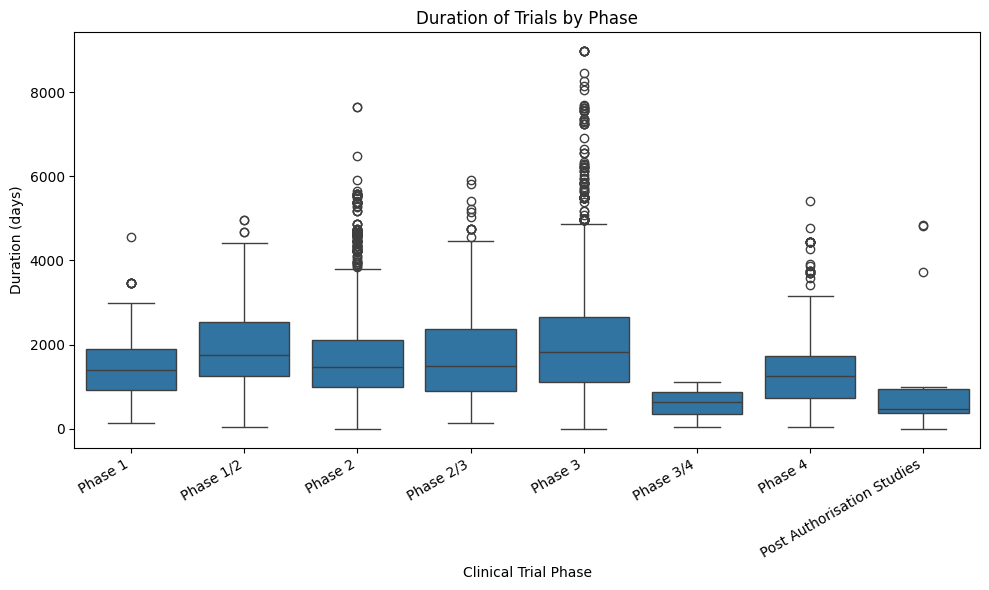

ANOVA one-way across phases: F = 47.002, p = 5.690e-66
→ Differenze di durata significative fra almeno due fasi.


In [21]:
from pyspark.sql.functions import col, to_date, datediff, count, mean, expr
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# Filtraggio per escludere date nulle e calcolo della durata in giorni
df_dur = (
    df_clinical
    .filter(
        col("Phase").isNotNull() &
        col("Start date").isNotNull() &
        col("End Date").isNotNull()
    )
    .withColumn("StartDate", to_date(col("Start date"), "yyyy-MM-dd"))
    .withColumn("EndDate",   to_date(col("End Date"),   "yyyy-MM-dd"))
    .withColumn("DurationDays", datediff(col("EndDate"), col("StartDate")))
    .select("Phase", "DurationDays")
)

# Conteggio delle fasi presenti nel dataset
df_dur.groupBy("Phase").agg(count("*").alias("cnt")).orderBy(expr("Phase")).show()

# Ordine delle fasi
desired_order = [
    "Phase 1", "Phase 1/2",
    "Phase 2", "Phase 2/3",
    "Phase 3", "Phase 3/4",
    "Phase 4", "Post Authorisation Studies"
]
phases_present = [ph for ph in desired_order
                  if ph in [row.Phase for row in df_dur.select("Phase").distinct().collect()]]


pdf_dur = df_dur.toPandas()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Phase",
    y="DurationDays",
    data=pdf_dur,
    order=phases_present
)
plt.title("Duration of Trials by Phase")
plt.xlabel("Clinical Trial Phase")
plt.ylabel("Duration (days)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# ANOVA
groups = [g["DurationDays"].values for _, g in pdf_dur.groupby("Phase")]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA one-way across phases: F = {f_stat:.3f}, p = {p_val:.3e}")
if p_val < 0.05:
    print("→ Differenze di durata significative fra almeno due fasi.")
else:
    print("→ Nessuna differenza significativa di durata fra le fasi.")